# Creating a dataset using nff's code and our database on HTVS

This tutorial addresses the problem of creating a database directly from our database for HTVS. It requires setting up the project `dbsetting` to make loading the data easier for this code

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import random
import numpy as np

import torch
from dbsetting import *
import nff.data as d

import matplotlib.pyplot as plt

### Ethanol calculations using DLPNO

For this example, we will create a dataset of hybrid calculations of ethanol molecules. In this example, we will extract all calculations from the database

In [3]:
myspecies = Species.objects.filter(smiles='COC')
mymethod = Method.objects.filter(name='dft_d3_dhyb_dsdpbebp86').first()
mycalcs = (Calc.objects
    .filter(method=mymethod)
    .filter(species__in=myspecies)
    .order_by('?')
)

Checking how many calcs we have for these systems:

In [4]:
mycalcs.count()

7814

### Creating the dataset with DLPNO properties

Retrieving the calculations:

In [5]:
geoms = Geom.objects.filter(
    id__in=mycalcs.values_list('geoms__id', flat=True)
)

dlpno_props = get_props(
    geoms,
    methodname=mymethod.name
)

### Creating a dataset of GGA properties for the same geoms

In [6]:
gga_method = Method.objects.filter(name='dft_d3_gga_bp86').first()
gga_props = get_props(
    geoms,
    methodname=gga_method.name
)

## Creating the dataset

To make the creation of the dataset easier, we have to convert the list of dicts into dict of dicts. Then, we can merge the dictionaries.

In [7]:
dlpno_props = {
    dict_['geom_id']: dict_
    for dict_ in dlpno_props
}

gga_props = {
    dict_['geom_id']: dict_
    for dict_ in gga_props
}

The Dataset requires a dictionary of lists for its properties. It also works with `energy_grad` instead of forces. To convert between the two, we have to invert the sign of the forces:

In [8]:
common_geoms = [x for x in dlpno_props.keys() if x in gga_props.keys()]

In [9]:
joint_props = []
for geom_id in common_geoms:
    joint_props.append({
        'geom_id': geom_id,
        'nxyz': dlpno_props[geom_id]['nxyz'],
        'energy_dlpno': dlpno_props[geom_id]['energy'],
        'energy_dlpno_grad': -np.array(dlpno_props[geom_id]['forces']),
        'energy_gga': gga_props[geom_id]['energy'],
        'energy_gga_grad': -np.array(gga_props[geom_id]['forces']),                
    })

In [10]:
props = d.concatenate_dict(*joint_props)

In [11]:
props['geom_id'] = torch.LongTensor(props['geom_id'])

### Creating the dataset

When creating the dataset, we have to supply it with the properties of interest and the units of the energy. The forces should be in the same system of units. XYZ positions should be in Å.

In [12]:
dataset = d.Dataset(props.copy(), units='atomic')

Here's an example of an item from the dataset:

In [13]:
dataset[0]

{'energy_dlpno': tensor(-97130.1719),
 'energy_gga_grad': tensor([[ 21.2910, -41.5670,  -6.9857],
         [  4.5007, -12.5286,   2.0307],
         [-40.5816, -85.2342,   1.6776],
         [  8.4962,  11.0011,   6.8332],
         [ -4.3553,  29.5203,   3.6987],
         [-14.6630,  10.1139,  -9.7044],
         [ 30.0551,  32.3086, -10.0928],
         [  3.5026,   7.8003, -16.8738],
         [ -8.2457,  48.5856,  29.4164]]),
 'geom_id': tensor(41195263),
 'nxyz': tensor([[ 6.0000,  1.1668,  0.0963, -0.0329],
         [ 8.0000,  0.1156, -0.8090,  0.2422],
         [ 6.0000, -1.1586, -0.2094,  0.0662],
         [ 1.0000,  1.1832,  0.5459, -1.0595],
         [ 1.0000,  1.0934,  1.0800,  0.5933],
         [ 1.0000,  2.1237, -0.3936,  0.0924],
         [ 1.0000, -1.9288, -0.8885,  0.3004],
         [ 1.0000, -1.2607,  0.1775, -1.0082],
         [ 1.0000, -1.3082,  0.8079,  0.7677]]),
 'energy_dlpno_grad': tensor([[  8.5893, -54.3899,  -1.9343],
         [  4.5687, -14.9591,   2.8017],
      

Calculating the length of the dataset:

In [14]:
len(dataset)

3894

## Changing the reference of the energies

As each method has different reference energies, it's more convenient to generate a dataset with a fixed internal reference. In this case, since all geometries are from the ethanol, all systems have the exact same stoichiometry reference. There is no problem, therefore, to choose one geometry as reference and use it calculate all other energies.

To start, we may want to plot the energy distribution for both systems:

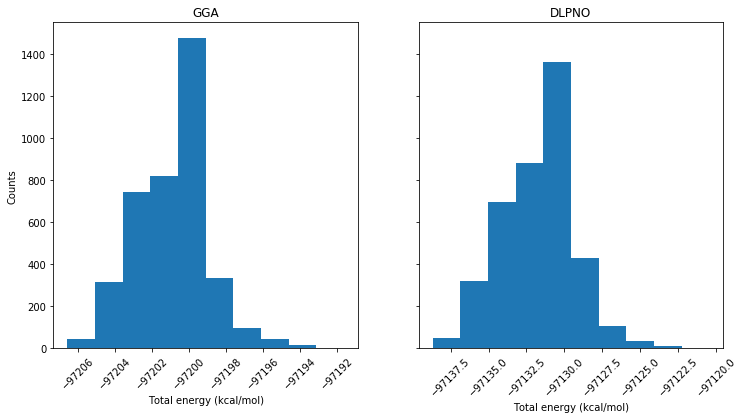

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

ax[0].hist([x.item() for x in dataset.props['energy_gga']])
ax[1].hist([x.item() for x in dataset.props['energy_dlpno']])

ax[0].set_title('GGA')
ax[1].set_title('DLPNO')

ax[0].set_ylabel('Counts')
ax[0].set_xlabel('Total energy (kcal/mol)')
ax[1].set_xlabel('Total energy (kcal/mol)')

for subax in ax:
    subax.tick_params(rotation=45, axis='x')
#     for tick in subax.get_xticks():
#         tick.set_params(rotation=45)
plt.show()

It's good to see that both methods have more or less the same distribution of total energies. Ideally, we want to choose any geometry that is more or less in the middle of both:

In [16]:
mean_dlpno = np.mean([x.data for x in dataset.props['energy_dlpno']])
mean_gga = np.mean([x.data for x in dataset.props['energy_gga']])

center_distribution = [
    x['geom_id'].item()
    for x in dataset
    if abs(x['energy_dlpno'] - mean_dlpno) < 0.1 and abs(x['energy_gga'] - mean_gga) < 0.1
]

Now we can choose any arbitrary geometry as reference:

In [17]:
reference_geom = random.sample(center_distribution, 1)[0]

In [18]:
for geom_id, dlpno, gga in zip(
    dataset.props['geom_id'],
    dataset.props['energy_dlpno'],
    dataset.props['energy_gga'],
):
    if geom_id == reference_geom:
        reference_props = {
            'energy_dlpno': dlpno,
            'energy_gga': gga
        }

In [19]:
for key in ['energy_dlpno', 'energy_gga']:
    dataset.props[key] = [
        x - reference_props[key]
        for x in dataset.props[key]
    ]

### Replotting the energy distributions

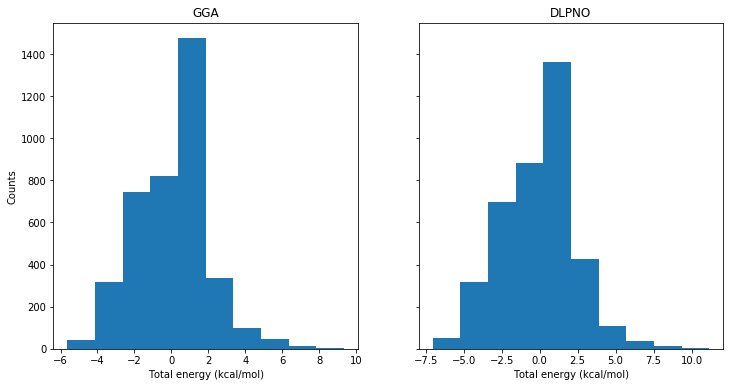

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

ax[0].hist([x.data for x in dataset.props['energy_gga']])
ax[1].hist([x.data for x in dataset.props['energy_dlpno']])

ax[0].set_title('GGA')
ax[1].set_title('DLPNO')

ax[0].set_ylabel('Counts')
ax[0].set_xlabel('Total energy (kcal/mol)')
ax[1].set_xlabel('Total energy (kcal/mol)')

plt.show()

Plotting a scatter plot of equivalences between DLPNO and GGA ethanol energies:

In [21]:
def plot_hexbin(pred, targ, ax, scale='log', plot_helper_lines=False): 
    
    units = {
        'force': r'kcal/mol/$\AA$',
        'energy': 'kcal/mol'
    }
    
    if scale == 'log':
        pred = np.abs(pred) + 1e-8
        targ = np.abs(targ) + 1e-8
    
    hb = ax.hexbin(
        pred, targ,
        cmap='viridis',
        gridsize=60,
        bins='log',
        mincnt=1,
        edgecolors=None,
        linewidths=(0.1,),
        xscale=scale,
        yscale=scale,
    )
    
    lim_min = min(np.min(pred), np.min(targ)) * 1.1
    lim_max = max(np.max(pred), np.max(targ)) * 1.1
    
    ax.set_xlim(lim_min, lim_max)
    ax.set_ylim(lim_min, lim_max)
    ax.set_aspect('equal')
    

    ax.plot((lim_min, lim_max),
            (lim_min, lim_max),
            color='#000000',
            zorder=-1,
            linewidth=0.5)
    
    if plot_helper_lines:
        
        if scale == 'linear':
            x = np.linspace(lim_min, lim_max, 50)
            y_up = x + mae
            y_down = x - mae         
            
        elif scale == 'log':
            x = np.logspace(np.log10(lim_min), np.log10(lim_max), 50)
            
            # one order of magnitude
            y_up = np.maximum(x + 1e-2, x * 10)
            y_down = np.minimum(np.maximum(1e-8, x - 1e-2), x / 10)
            
            # one kcal/mol/Angs
            y_up = x + 1
            y_down = np.maximum(1e-8, x - 1)
            
        
        for y in [y_up, y_down]:
            ax.plot(x,
                    y,
                    color='#000000',
                    zorder=2,
                    linewidth=0.5,
                    linestyle='--')
    
    return ax, hb

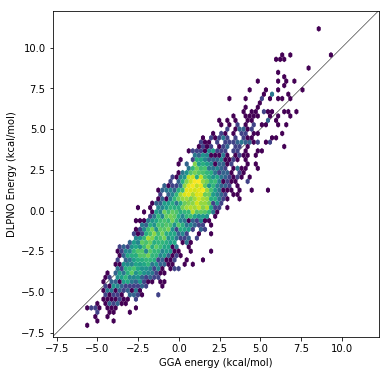

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), sharey=True)

plot_hexbin(
    np.array([x.data for x in dataset.props['energy_gga']]),
    np.array([y.data for y in dataset.props['energy_dlpno']]),
    ax=ax,
    scale='linear'
)

ax.set_xlabel('GGA energy (kcal/mol)')
ax.set_ylabel('DLPNO Energy (kcal/mol)')

plt.show()

### Generating neighbor list

Managing the neighbor list of the input graphs is the responsibility of the data. The dataset has an in-built function to do so. It requires only the cutoff (in Å) to define atoms as neighbors:

In [23]:
dataset.generate_neighbor_list(cutoff=5)

### Loading/saving dataset from file

We can save this dataset to a file by using its in-build method:

In [24]:
dataset.save('dataset_dlpno.pth.tar')